In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

import string 
import re

from sklearn import  metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

import warnings

warnings.filterwarnings("ignore")

### Data base import - 'otodom_file.csv'

In [2]:
otodom = pd.read_csv('otodom_file',index_col=0)
otodom.head()

,nazwa,typ_oferty,zdjecie_link,lokalizacja,miejscowosc,cena_PLN,cena_za_m2,Powierzchnia,Liczba pokoi,Rynek,...,Piętro,Liczba pięter,Okna,Ogrzewanie,Rok budowy,Stan wykończenia,Czynsz,Forma własności,Materiał budynku,Dostępne od
0,Apartament 145m2 z antresolą Wola Justowska,Mieszkanie na sprzedaż,https://www.otodom.pl/frontera/static/media/lo...,"Kraków, Zwierzyniec, Wola Justowska, Piotra Bo...",Kraków,1690000.0,11615.0,145.50,5,pierwotny,...,2,2.0,aluminiowe,inne,2019.0,do wykończenia,1100,pełna własność,NaN,NaN
1,"Mieszkanie, 38 m², Kraków",Mieszkanie na sprzedaż,https://www.otodom.pl/frontera/static/media/lo...,"Kraków, Podgórze, Płaszów",Kraków,379000.0,9974.0,38.00,2,wtórny,...,9,10.0,plastikowe,miejskie,NaN,NaN,250,NaN,NaN,NaN
2,"ul. Czarnogórska 18, 57 m2 dwa balkony + garaż",Mieszkanie na sprzedaż,https://www.otodom.pl/frontera/static/media/lo...,"Kraków, Podgórze Duchackie, Wola Duchacka, ul....",Kraków,545000.0,9501.0,57.36,3,wtórny,...,1,3.0,plastikowe,miejskie,2009.0,do zamieszkania,500,pełna własność,pustak,NaN
3,2pok 47m2 ok. ul. Kobierzyńska Łagiewniki/Ruczaj,Mieszkanie na sprzedaż,https://www.otodom.pl/frontera/static/media/lo...,"Kraków, Łagiewniki-Borek Fałęcki, Łagiewniki",Kraków,364737.0,7690.0,47.43,2,pierwotny,...,parter,3.0,plastikowe,NaN,2021.0,NaN,NaN,NaN,NaN,NaN
4,2pok 47m2 ok. ul. Kobierzyńska Łagiewniki/Ruczaj,Mieszkanie na sprzedaż,https://www.otodom.pl/frontera/static/media/lo...,"Kraków, Łagiewniki-Borek Fałęcki, Łagiewniki",Kraków,358892.0,7690.0,46.67,2,pierwotny,...,parter,3.0,plastikowe,NaN,2021.0,NaN,NaN,NaN,NaN,NaN


In [3]:
otodom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7863 entries, 0 to 7862
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   nazwa             7863 non-null   object 
 1   typ_oferty        7863 non-null   object 
 2   zdjecie_link      7863 non-null   object 
 3   lokalizacja       7863 non-null   object 
 4   miejscowosc       7863 non-null   object 
 5   cena_PLN          7763 non-null   float64
 6   cena_za_m2        7763 non-null   float64
 7   Powierzchnia      7313 non-null   float64
 8   Liczba pokoi      7313 non-null   object 
 9   Rynek             7313 non-null   object 
 10  Rodzaj zabudowy   5979 non-null   object 
 11  Piętro            7151 non-null   object 
 12  Liczba pięter     6539 non-null   float64
 13  Okna              4583 non-null   object 
 14  Ogrzewanie        5037 non-null   object 
 15  Rok budowy        5966 non-null   float64
 16  Stan wykończenia  3562 non-null   object 


**As per the requirements of otodom.pl, the following credentials are obligatory:**

- nazwa (name)
- cena_PLN (but when the user select 'Ask for a price' it can stay blank - in such situation row to be removed) (price in PLN)
- Powierzchnia (m^2) (space)
- Liczba pokoi (number of rooms)
- Rynek (can be only pierwotny or wtórny) (brand new/used)
- Lokalizacja (miejscowosc) (localization)

**additionaly those fields are added automatically:**

- typ_oferty (offer typ)
- zdjecie_link (picture_link)
- cena_za_m2 (price per m2)

**All other fields are optional, but most of them have standard description to be chosen:**

- Rodzaj zabudowy: NaN, blok, kamienica, dom wolnostojacy, plomba, szeregowiec, apartamentowiec, loft (building type)
- Piętro: NaN, suterena, parter, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, > 10, poddasze (floor)
- Materiał budynku: NaN, cegła, drewno, pustak, keramzyt, wielka płyta, beton, silikat, beton komórkowy, zelbet, inne (building material)
- Okna: NaN, plastikowe, drewniane, aluminiowe (windows made of)
- Ogrzewanie: NaN, miejskie, gazowe, piece kaflowe, elektryczne, kotłownia, inne (heating)
- Stan wykończenia: NaN, do zamieszkania, do wykończenia, do remontu (ready to use/to be renovate)
- Forma własności: NaN, spółdzielcze wł. z KW, spółdzielcze własnościowe, pełna własność, udział (ownership type)

### All rows where the price of the apartment is unknown are removed

In [4]:
otodom.dropna(subset=['cena_PLN'],inplace=True)
otodom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7763 entries, 0 to 7862
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   nazwa             7763 non-null   object 
 1   typ_oferty        7763 non-null   object 
 2   zdjecie_link      7763 non-null   object 
 3   lokalizacja       7763 non-null   object 
 4   miejscowosc       7763 non-null   object 
 5   cena_PLN          7763 non-null   float64
 6   cena_za_m2        7763 non-null   float64
 7   Powierzchnia      7227 non-null   float64
 8   Liczba pokoi      7227 non-null   object 
 9   Rynek             7227 non-null   object 
 10  Rodzaj zabudowy   5912 non-null   object 
 11  Piętro            7065 non-null   object 
 12  Liczba pięter     6472 non-null   float64
 13  Okna              4539 non-null   object 
 14  Ogrzewanie        4993 non-null   object 
 15  Rok budowy        5922 non-null   float64
 16  Stan wykończenia  3518 non-null   object 


### Location ('lokalizacja') as important and messy field, needs to be cleaned up

In [5]:
otodom['lokalizacja'].value_counts()

Kraków, Prądnik Biały                                                 244
Kraków, Krowodrza                                                     227
Kraków, Dębniki                                                       165
Kraków, Stare Miasto                                                  156
Kraków, Grzegórzki                                                    155
                                                                     ... 
Kraków, Podgórze Duchackie, Wola Duchacka, ul. Beskidzka                1
Kraków, Prądnik Biały, Żabiniec, ul. Andrzeja Frycza-Modrzewskiego      1
Kraków, Krowodrza, Hamernia                                             1
Kraków, Stare Miasto, al. Ignacego Daszyńskiego                         1
Kraków, Podgórze, ul. Komandosów                                        1
Name: lokalizacja, Length: 1972, dtype: int64

### The location ('lokalizacja') is split by coma into columns.

In [6]:
otodom['lok_dzielnica']=otodom['lokalizacja'].str.split(', ', expand=True)[1]

### In most cases second variable from the split presents city area in which apartment is located

In [7]:
otodom['lok_dzielnica'].value_counts()

Dębniki                     997
Prądnik Biały               826
Stare Miasto                784
Podgórze                    708
Krowodrza                   690
Grzegórzki                  594
Nowa Huta                   438
Bronowice                   435
Podgórze Duchackie          394
Prądnik Czerwony            379
Bieżanów-Prokocim           330
Zwierzyniec                 326
Mistrzejowice               256
Śródmieście                 228
Łagiewniki-Borek Fałęcki    135
Swoszowice                   70
Bieńczyce                    58
małopolskie                  57
Kraków                       29
Wzgórza Krzesławickie        28
Ruczaj                        1
Name: lok_dzielnica, dtype: int64

### As this creadential is field by seler, letter size needs to be stadardize

In [8]:
otodom['lok_dzielnica']=[dzielnica.upper() for dzielnica in otodom['lok_dzielnica']]

In [9]:
otodom['lok_dzielnica'].value_counts()

DĘBNIKI                     997
PRĄDNIK BIAŁY               826
STARE MIASTO                784
PODGÓRZE                    708
KROWODRZA                   690
GRZEGÓRZKI                  594
NOWA HUTA                   438
BRONOWICE                   435
PODGÓRZE DUCHACKIE          394
PRĄDNIK CZERWONY            379
BIEŻANÓW-PROKOCIM           330
ZWIERZYNIEC                 326
MISTRZEJOWICE               256
ŚRÓDMIEŚCIE                 228
ŁAGIEWNIKI-BOREK FAŁĘCKI    135
SWOSZOWICE                   70
BIEŃCZYCE                    58
MAŁOPOLSKIE                  57
KRAKÓW                       29
WZGÓRZA KRZESŁAWICKIE        28
RUCZAJ                        1
Name: lok_dzielnica, dtype: int64

### Additionaly all unneeded punctuations are removed

In [10]:
table = str.maketrans({key: ' ' for key in string.punctuation})

otodom['lok_dzielnica'] = [dzielnica.translate(table) for dzielnica in otodom['lok_dzielnica']]

In [11]:
otodom['lok_dzielnica'].value_counts()

DĘBNIKI                     997
PRĄDNIK BIAŁY               826
STARE MIASTO                784
PODGÓRZE                    708
KROWODRZA                   690
GRZEGÓRZKI                  594
NOWA HUTA                   438
BRONOWICE                   435
PODGÓRZE DUCHACKIE          394
PRĄDNIK CZERWONY            379
BIEŻANÓW PROKOCIM           330
ZWIERZYNIEC                 326
MISTRZEJOWICE               256
ŚRÓDMIEŚCIE                 228
ŁAGIEWNIKI BOREK FAŁĘCKI    135
SWOSZOWICE                   70
BIEŃCZYCE                    58
MAŁOPOLSKIE                  57
KRAKÓW                       29
WZGÓRZA KRZESŁAWICKIE        28
RUCZAJ                        1
Name: lok_dzielnica, dtype: int64

### Areas 'MAŁOPOLSKIE' and 'KRAKÓW' means nothing - replaced by other 'INNE', on top of that all areas which occur less than 25 times are added to the same bucket

In [12]:
other_areas = ["MAŁOPOLSKIE","KRAKÓW"]
city_areas = otodom.lok_dzielnica.unique()

for i in city_areas:
    if otodom.loc[otodom.lok_dzielnica==i,'lok_dzielnica'].count() <25:
        other_areas.append(i) 
    
other_areas

['MAŁOPOLSKIE', 'KRAKÓW', 'RUCZAJ']

In [13]:
for i in other_areas:
    otodom.loc[(otodom.lok_dzielnica == i),'lok_dzielnica']='INNE'
    
otodom['lok_dzielnica'].value_counts()

DĘBNIKI                     997
PRĄDNIK BIAŁY               826
STARE MIASTO                784
PODGÓRZE                    708
KROWODRZA                   690
GRZEGÓRZKI                  594
NOWA HUTA                   438
BRONOWICE                   435
PODGÓRZE DUCHACKIE          394
PRĄDNIK CZERWONY            379
BIEŻANÓW PROKOCIM           330
ZWIERZYNIEC                 326
MISTRZEJOWICE               256
ŚRÓDMIEŚCIE                 228
ŁAGIEWNIKI BOREK FAŁĘCKI    135
INNE                         87
SWOSZOWICE                   70
BIEŃCZYCE                    58
WZGÓRZA KRZESŁAWICKIE        28
Name: lok_dzielnica, dtype: int64

In [14]:
city_areas_final = otodom.lok_dzielnica.unique()

### Utilities 'Czynsz' are treated by data frame as object. Simple way, fractions are removed and values are saved as floats

In [15]:
otodom["Czynsz"] = otodom["Czynsz"].str.split(',', expand=True)[0]

In [16]:
otodom["Czynsz"] = pd.Series(otodom["Czynsz"], dtype= 'float64')

In [17]:
otodom["Czynsz"].value_counts()

400.0    230
350.0    179
500.0    162
300.0    161
450.0    131
        ... 
415.0      1
730.0      1
305.0      1
596.0      1
439.0      1
Name: Czynsz, Length: 297, dtype: int64

### Utilities 'Czynsz' correction revision.

In [18]:
otodom["Czynsz"].describe()

count    2640.000000
mean      417.701515
std       210.397384
min         1.000000
25%       300.000000
50%       400.000000
75%       500.000000
max      3000.000000
Name: Czynsz, dtype: float64

### Fees over 1000 PLN and below 100 PLN do not have any sense, they are replaced by np.nan

In [19]:
otodom['Czynsz'] = np.where(otodom['Czynsz']<100.0,np.nan,otodom['Czynsz'])
otodom['Czynsz'] = np.where(otodom['Czynsz']>1000.0,np.nan,otodom['Czynsz'])

In [20]:
otodom["Czynsz"].value_counts()

400.0    230
350.0    179
500.0    162
300.0    161
450.0    131
        ... 
316.0      1
946.0      1
212.0      1
225.0      1
305.0      1
Name: Czynsz, Length: 261, dtype: int64

### Number of rooms 'Liczba pokoi' revision.

In [21]:
otodom["Liczba pokoi"].value_counts()

2                2664
3                2564
4                 866
1                 800
5                 241
6                  58
7                  12
8                  10
więcej niż 10       8
10                  3
9                   1
Name: Liczba pokoi, dtype: int64

### Number of rooms 'Liczba pokoi' aligmnet to number

In [22]:
otodom.loc[(otodom['Liczba pokoi'] == "więcej niż 10"),'Liczba pokoi']='11'

In [23]:
otodom["Liczba pokoi"].value_counts()

2     2664
3     2564
4      866
1      800
5      241
6       58
7       12
8       10
11       8
10       3
9        1
Name: Liczba pokoi, dtype: int64

In [24]:
otodom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7763 entries, 0 to 7862
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   nazwa             7763 non-null   object 
 1   typ_oferty        7763 non-null   object 
 2   zdjecie_link      7763 non-null   object 
 3   lokalizacja       7763 non-null   object 
 4   miejscowosc       7763 non-null   object 
 5   cena_PLN          7763 non-null   float64
 6   cena_za_m2        7763 non-null   float64
 7   Powierzchnia      7227 non-null   float64
 8   Liczba pokoi      7227 non-null   object 
 9   Rynek             7227 non-null   object 
 10  Rodzaj zabudowy   5912 non-null   object 
 11  Piętro            7065 non-null   object 
 12  Liczba pięter     6472 non-null   float64
 13  Okna              4539 non-null   object 
 14  Ogrzewanie        4993 non-null   object 
 15  Rok budowy        5922 non-null   float64
 16  Stan wykończenia  3518 non-null   object 


### Selection of columns which are expected to be a base of estimation (skipped: name/description 'nazwa' website link 'zdjecie_link', ofer type 'typ_oferty' and location 'lokalizacja')

In [25]:
otodom_new = otodom[['miejscowosc','lok_dzielnica','Powierzchnia','Liczba pokoi','Rynek','Rodzaj zabudowy',
                    'Piętro','Liczba pięter','Okna','Ogrzewanie','Rok budowy','Stan wykończenia','Czynsz',
                     'Materiał budynku','Forma własności','cena_PLN']]

### Market 'Rynek' has only 2 otpions new apartment 'pierwotny' and used 'wtórny' - aligment to 0 and 1

In [26]:
otodom_new['Rynek'] = np.where(otodom['Rynek']=='pierwotny',0,1)

In [27]:
otodom_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7763 entries, 0 to 7862
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   miejscowosc       7763 non-null   object 
 1   lok_dzielnica     7763 non-null   object 
 2   Powierzchnia      7227 non-null   float64
 3   Liczba pokoi      7227 non-null   object 
 4   Rynek             7763 non-null   int64  
 5   Rodzaj zabudowy   5912 non-null   object 
 6   Piętro            7065 non-null   object 
 7   Liczba pięter     6472 non-null   float64
 8   Okna              4539 non-null   object 
 9   Ogrzewanie        4993 non-null   object 
 10  Rok budowy        5922 non-null   float64
 11  Stan wykończenia  3518 non-null   object 
 12  Czynsz            2527 non-null   float64
 13  Materiał budynku  2721 non-null   object 
 14  Forma własności   4442 non-null   object 
 15  cena_PLN          7763 non-null   float64
dtypes: float64(5), int64(1), object(10)
memory

### X,y definition, additionaly removing column city 'miejscowosc' as this analysis consider only Kraków

In [28]:
X = otodom_new.drop(['cena_PLN'], axis=1)
X = otodom_new.drop(['miejscowosc'],axis=1)
y = otodom_new['cena_PLN']

### Test&train split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

### Pipline creation:
- muneric_pipline uses mean strategy to fill nan 'Powierzchnia' and 'Czynsz'
- numeric_pipline uses most_frequent startegy to fill nan 'Rok budowy', 'Liczba pokoi','Rynek'
- cat_pipline works on text, uses most_frequent startegy to fill nan 'lok_dzielnica','Rodzaj zabudowy','Okna','Ogrzewanie','Stan wykończenia','Materiał budynku','Forma własności','Piętro', and the by OneHotEncoder split variables into separate columns

In [30]:
numeric_columns = ['Powierzchnia','Czynsz']
numeric_columns_2 = ['Rok budowy', 'Liczba pokoi','Rynek']
cat_columns     = ['lok_dzielnica','Rodzaj zabudowy','Okna','Ogrzewanie','Stan wykończenia',
                   'Materiał budynku','Forma własności','Piętro']

numeric_pipeline = make_pipeline(SimpleImputer(strategy='mean'),StandardScaler())
numeric_pipeline_2 = make_pipeline(SimpleImputer(strategy='most_frequent'),StandardScaler())
cat_pipeline     = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                 OneHotEncoder(sparse=False, handle_unknown = 'ignore'))

transformers = [('num', numeric_pipeline, numeric_columns),('num2', numeric_pipeline_2, numeric_columns_2),
                ('cat', cat_pipeline, cat_columns)]

combined_pipe = ColumnTransformer(transformers)

### Defined earlier data set X is here transformed by pipelines and the column names are added for further data analisis 

In [31]:
transformed_data = combined_pipe.fit_transform(X)


def get_transformer_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

In [32]:
get_transformer_feature_names(combined_pipe)

['Powierzchnia',
 'Czynsz',
 'Rok budowy',
 'Liczba pokoi',
 'Rynek',
 'lok_dzielnica_BIEŃCZYCE',
 'lok_dzielnica_BIEŻANÓW PROKOCIM',
 'lok_dzielnica_BRONOWICE',
 'lok_dzielnica_DĘBNIKI',
 'lok_dzielnica_GRZEGÓRZKI',
 'lok_dzielnica_INNE',
 'lok_dzielnica_KROWODRZA',
 'lok_dzielnica_MISTRZEJOWICE',
 'lok_dzielnica_NOWA HUTA',
 'lok_dzielnica_PODGÓRZE',
 'lok_dzielnica_PODGÓRZE DUCHACKIE',
 'lok_dzielnica_PRĄDNIK BIAŁY',
 'lok_dzielnica_PRĄDNIK CZERWONY',
 'lok_dzielnica_STARE MIASTO',
 'lok_dzielnica_SWOSZOWICE',
 'lok_dzielnica_WZGÓRZA KRZESŁAWICKIE',
 'lok_dzielnica_ZWIERZYNIEC',
 'lok_dzielnica_ŁAGIEWNIKI BOREK FAŁĘCKI',
 'lok_dzielnica_ŚRÓDMIEŚCIE',
 'Rodzaj zabudowy_apartamentowiec',
 'Rodzaj zabudowy_blok',
 'Rodzaj zabudowy_dom wolnostojący',
 'Rodzaj zabudowy_kamienica',
 'Rodzaj zabudowy_plomba',
 'Rodzaj zabudowy_szeregowiec',
 'Okna_aluminiowe',
 'Okna_drewniane',
 'Okna_plastikowe',
 'Ogrzewanie_elektryczne',
 'Ogrzewanie_gazowe',
 'Ogrzewanie_inne',
 'Ogrzewanie_kotłownia'

### Modified data are transformed into Data Frame and standardize price 'Czena_PLN' is added

In [33]:
data = pd.DataFrame(transformed_data,columns=get_transformer_feature_names(combined_pipe))
y_new = y.values
y_new = y_new.reshape(-1,1)
y_new=StandardScaler().fit_transform(y_new)
y_new = pd.DataFrame(y_new,columns=['Cena_PLN'])
data_to_analyze = pd.concat([data,y_new], axis = 1)

In [34]:
data_to_analyze.head()

,Powierzchnia,Czynsz,Rok budowy,Liczba pokoi,Rynek,lok_dzielnica_BIEŃCZYCE,lok_dzielnica_BIEŻANÓW PROKOCIM,lok_dzielnica_BRONOWICE,lok_dzielnica_DĘBNIKI,lok_dzielnica_GRZEGÓRZKI,...,Piętro_5,Piętro_6,Piętro_7,Piętro_8,Piętro_9,Piętro_> 10,Piętro_parter,Piętro_poddasze,Piętro_suterena,Cena_PLN
0,1.081159,6.042888e-16,0.070496,2.270352,-1.352817,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.163568
1,-0.284291,-1.806607e+00,0.074874,-0.570058,0.739198,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.468922
2,-0.038383,8.510835e-01,0.026714,0.376745,0.739198,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.135594
3,-0.164513,6.042888e-16,0.079253,-0.570058,-1.352817,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.497563
4,-0.174166,6.042888e-16,0.079253,-0.570058,-1.352817,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.509299


### Heatmap for data correcaltion analysis - saved as picture to see better:
- size of appartment, utilities, new/used appartment and area are higlhy correlated with the price

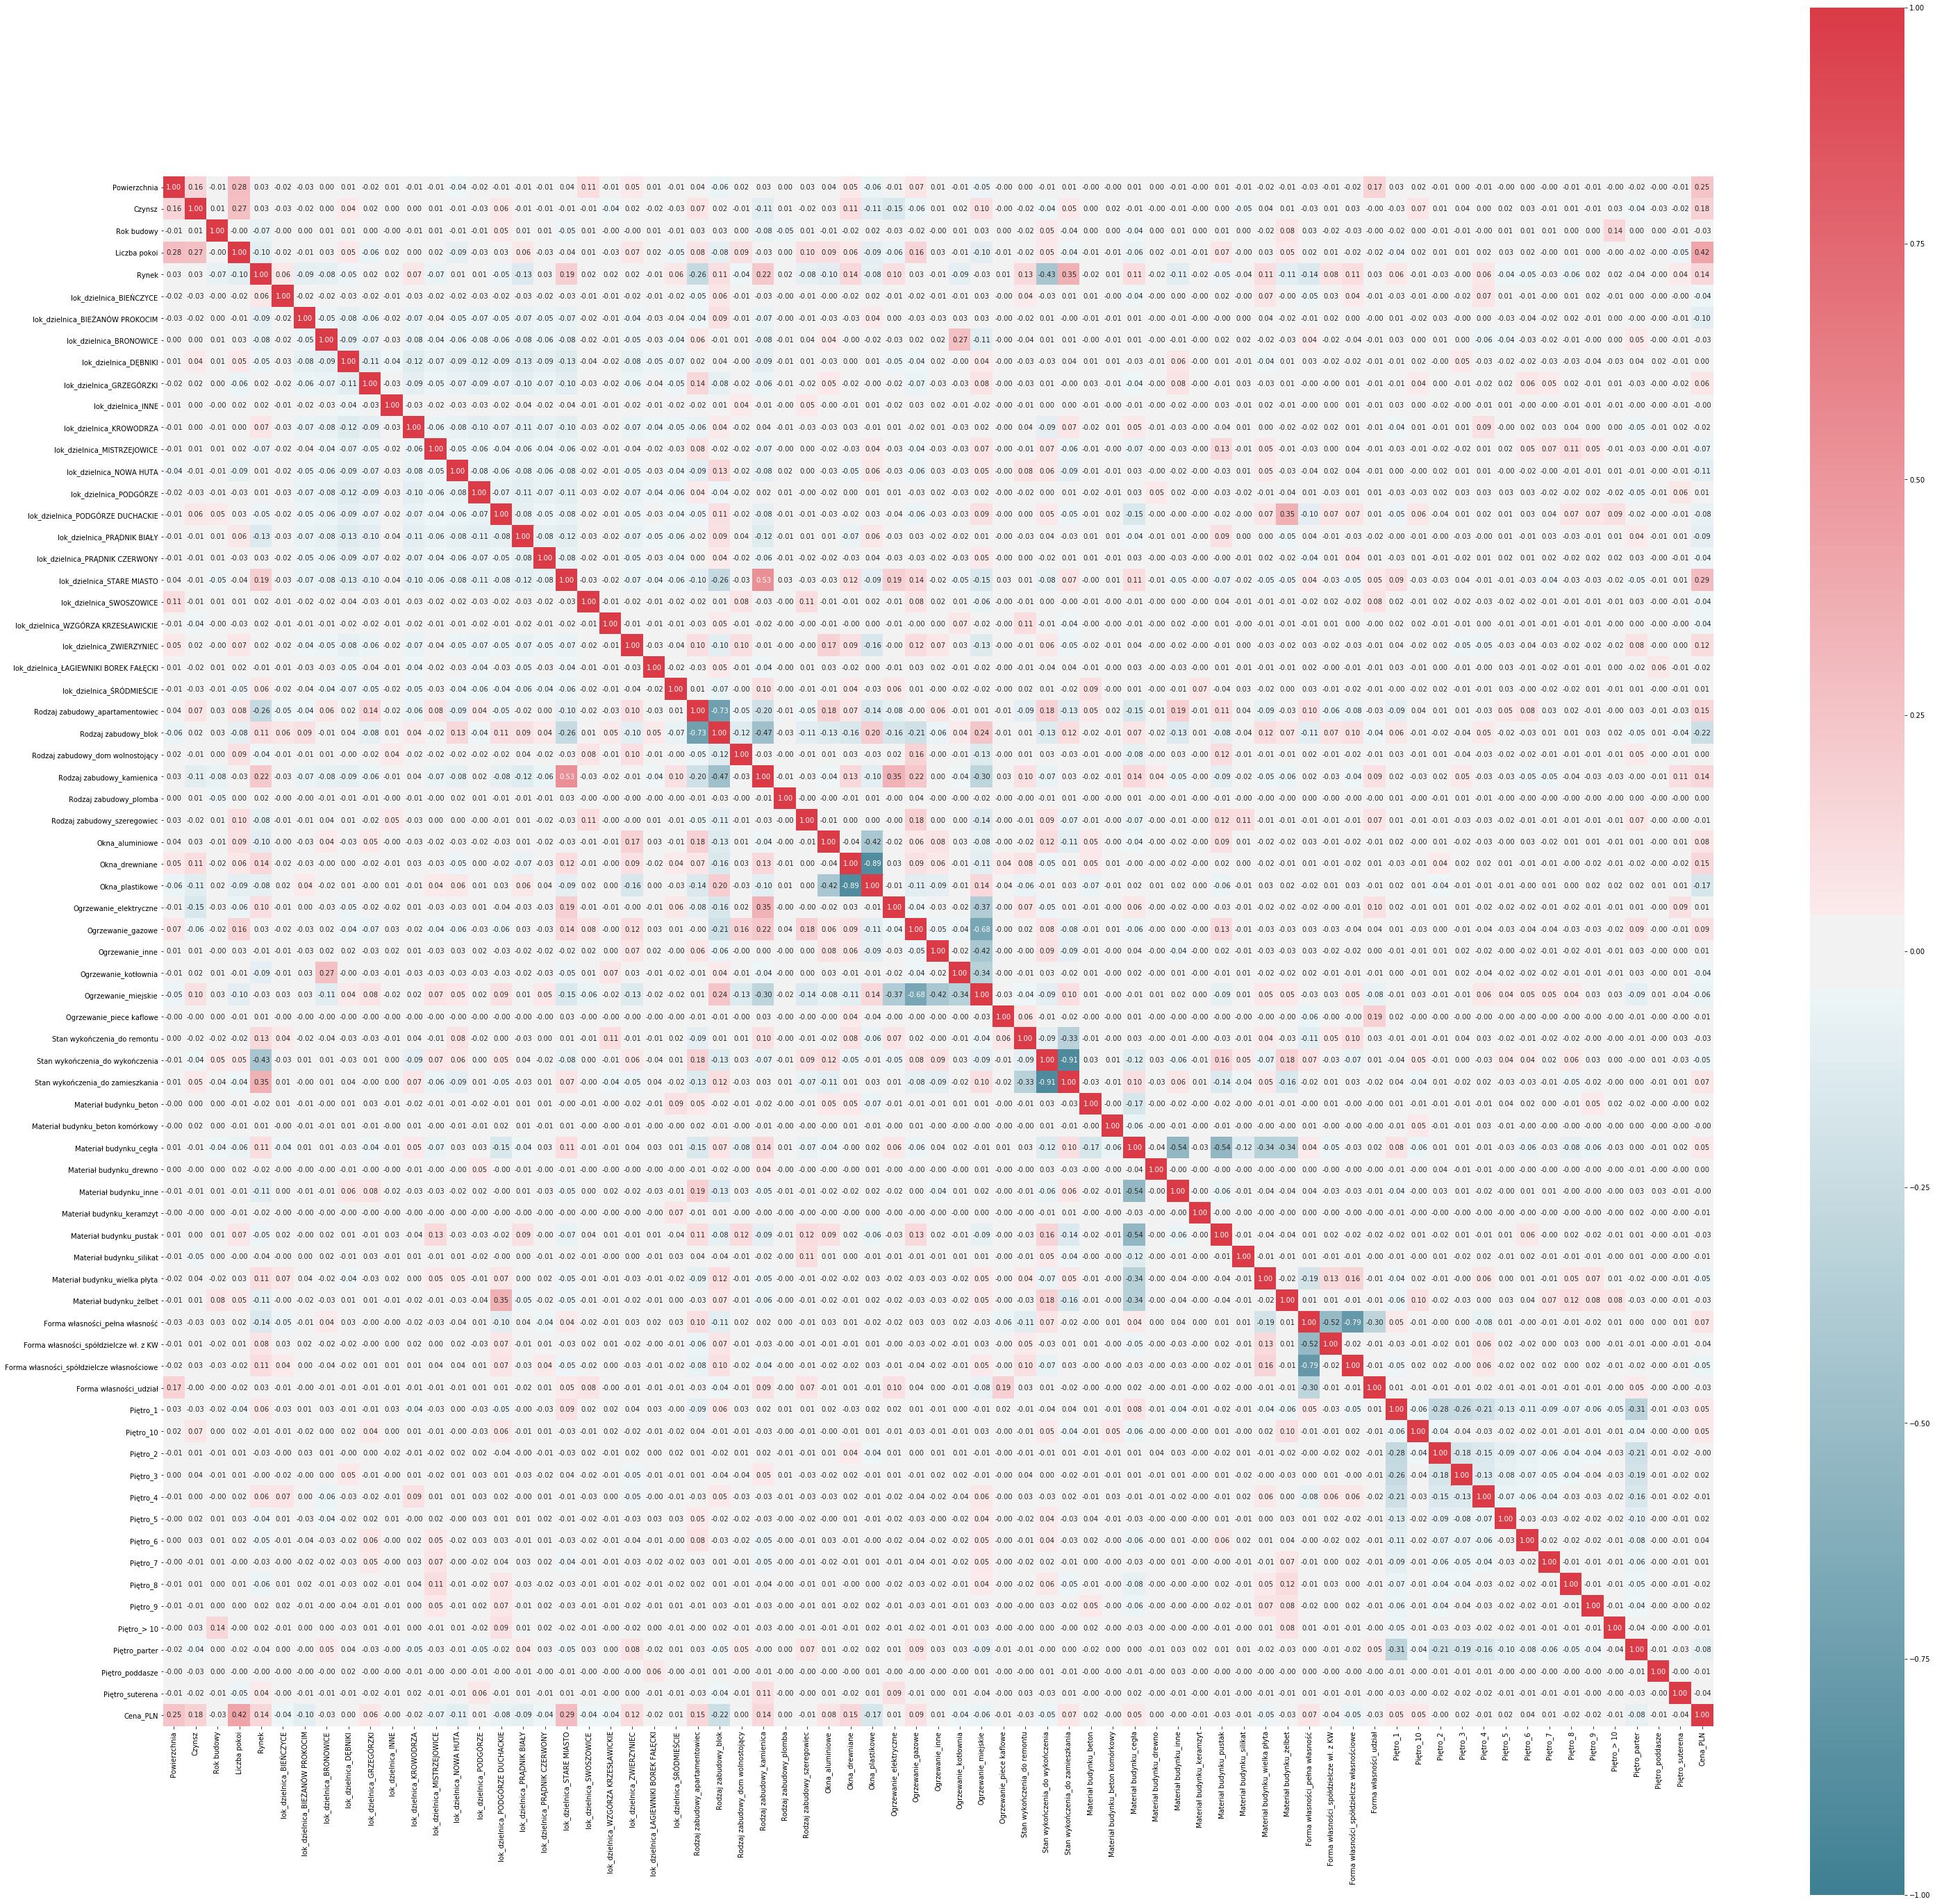

In [35]:
fig, ax = plt.subplots(figsize=(50,50)) 
sns.heatmap(data_to_analyze.corr(), vmax=1,vmin=-1,annot=True,square=True,
            cmap = sns.diverging_palette(220, 10, as_cmap=True),fmt='.2f')
plt.show()

### Kfold definition

In [36]:
kfold = KFold(n_splits=5)

### ElasticNet prediction

In [37]:
pipe1 = Pipeline([
    ('preprocessing', combined_pipe), ('scale', StandardScaler()),
    ('elasticnet', ElasticNet())])


param_grid1 = {'elasticnet__alpha': [0.001,0.005,0.01,0.05,0.1,0.5,1,2,3,4,5,6,7,8,9,10,15,20,25,50,75,100], 
              'elasticnet__l1_ratio':[0,0.25,0.5,0.75,1]}

grid_1 = GridSearchCV(pipe1, param_grid1, cv=kfold, n_jobs=-1)

In [38]:
grid_1.fit(X_train, y_train)
grid_1.best_params_

{'elasticnet__alpha': 6, 'elasticnet__l1_ratio': 0}

### Ridge prediction

In [39]:
pipe2 = Pipeline([
    ('preprocessing', combined_pipe), ('scale', StandardScaler()),
    ('ridge', Ridge())])


param_grid2 = {'ridge__alpha': [0.001,0.005,0.01,0.05,0.1,0.5,1,2,3,4,5,6,7,8,9,10,15,20,25,50,75,100]}

grid_2 = GridSearchCV(pipe2, param_grid2, cv=kfold, n_jobs=-1)

In [40]:
grid_2.fit(X_train, y_train)
grid_2.best_params_

{'ridge__alpha': 100}

### Lasso prediction

In [41]:
pipe3 = Pipeline([
    ('preprocessing', combined_pipe), ('scale', StandardScaler()),
    ('lasso', Lasso())])


param_grid3 = {'lasso__alpha': [0.001,0.005,0.01,0.05,0.1,0.5,1,2,3,4,5,6,7,8,9,10,15,20,25,50,75,100]}

grid_3 = GridSearchCV(pipe3, param_grid3, cv=kfold, n_jobs=-1)

In [42]:
grid_3.fit(X_train, y_train)
grid_3.best_params_

{'lasso__alpha': 100}

### KNeighborsRegressor prediction

In [74]:
pipe4 = Pipeline([
    ('preprocessing', combined_pipe), ('scale', StandardScaler()),
    ('regressor', KNeighborsRegressor())])


param_grid4 = {'regressor__n_neighbors': [3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
              'regressor__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'regressor__leaf_size':[3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]}

grid_4 = GridSearchCV(pipe4, param_grid4, cv=kfold, n_jobs=-1)

In [75]:
grid_4.fit(X_train, y_train)
grid_4.best_params_

{'regressor__algorithm': 'ball_tree',
 'regressor__leaf_size': 80,
 'regressor__n_neighbors': 3}

### DecisionTreeRegressor prediction

In [45]:
pipe5 = Pipeline([
    ('preprocessing', combined_pipe), ('scale', StandardScaler()),
    ('regressor', DecisionTreeRegressor())])


param_grid5 = {'regressor__max_depth': [3,5,10,15,20,25,30,35,40,45,50],
              'regressor__max_leaf_nodes':[3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
              'regressor__min_samples_leaf':[3,5,7,10,15,20,25,30,35,40,45,50]}

grid_5 = GridSearchCV(pipe5, param_grid5, cv=kfold, n_jobs=-1)

In [46]:
grid_5.fit(X_train, y_train)
grid_5.best_params_

{'regressor__max_depth': 20,
 'regressor__max_leaf_nodes': 100,
 'regressor__min_samples_leaf': 10}

### ExtraTreesRegressor prediction

In [47]:
pipe6 = Pipeline([
    ('preprocessing', combined_pipe), ('scale', StandardScaler()),
    ('regressor', ExtraTreesRegressor())])


param_grid6 = {'regressor__n_estimators': [3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
               'regressor__max_leaf_nodes':[3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
              'regressor__max_samples':[3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]}

grid_6 = GridSearchCV(pipe6, param_grid6, cv=kfold, n_jobs=-1)


In [48]:
grid_6.fit(X_train, y_train)
grid_6.best_params_

{'regressor__max_leaf_nodes': 100,
 'regressor__max_samples': 50,
 'regressor__n_estimators': 15}

### RandomForestRegressor prediction

In [49]:
pipe7 = Pipeline([
    ('preprocessing', combined_pipe), ('scale', StandardScaler()),
    ('regressor', RandomForestRegressor())])


param_grid7 = {'regressor__n_estimators': [3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
               'regressor__max_leaf_nodes':[3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
              'regressor__max_samples':[3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]}

grid_7 = GridSearchCV(pipe7, param_grid7, cv=kfold, n_jobs=-1)


In [50]:
grid_7.fit(X_train, y_train)
grid_7.best_params_

{'regressor__max_leaf_nodes': 85,
 'regressor__max_samples': 95,
 'regressor__n_estimators': 55}

### GradientBoostingRegressor prediction

In [76]:
pipe8 = Pipeline([
    ('preprocessing', combined_pipe), ('scale', StandardScaler()),
    ('regressor', GradientBoostingRegressor())])


param_grid8 = {'regressor__n_estimators': [25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400],
              'regressor__min_samples_leaf':[3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
              'regressor__max_depth':[3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]}

grid_8 = GridSearchCV(pipe8, param_grid8, cv=kfold, n_jobs=-1)


In [77]:
grid_8.fit(X_train, y_train)
grid_8.best_params_

{'regressor__max_depth': 95,
 'regressor__min_samples_leaf': 15,
 'regressor__n_estimators': 150}

### AdaBoostRegressor predition

In [79]:
pipe9 = Pipeline([('preprocessing', combined_pipe), ('scale', StandardScaler()),
                   ('regressor', AdaBoostRegressor())])



param_grid9 = {'regressor__base_estimator': [ElasticNet(alpha=6, l1_ratio = 0),
                                       Lasso(alpha=100), 
                                       Ridge(alpha=100),
                                       KNeighborsRegressor(algorithm='ball_tree',leaf_size=80,n_neighbors=3),
                                       DecisionTreeRegressor(max_depth=20,max_leaf_nodes=100,min_samples_leaf=10),
                                       ExtraTreesRegressor(max_leaf_nodes=100,max_samples=50,n_estimators=15),
                                       RandomForestRegressor(max_leaf_nodes=85,max_samples=95,n_estimators=55),
                                       GradientBoostingRegressor(n_estimators=150,min_samples_leaf=15,max_depth=95)],
              'regressor__n_estimators':[5,10,25,50,75,100],
              'regressor__loss':['linear', 'square','exponential']}

grid_9= GridSearchCV(pipe9, param_grid9, cv=kfold, n_jobs=-1)

In [80]:
grid_9.fit(X_train, y_train)
grid_9.best_params_

{'regressor__base_estimator': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=95,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=15, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 'regressor__loss': 'exponential',
 'regressor__n_estimators': 5}

### Models comparison ($R^2$ score, MSE, RMSE)

In [81]:
model_names = ['ElasticNet','Ridge','Lasso','KNeighbors','DecisionTree','ExtraTrees',
               'RandomForest','GradientBoosting','AdaBoost']


R2_EN = metrics.r2_score(y_test, grid_1.predict(X_test))
R2_Ridge = metrics.r2_score(y_test, grid_2.predict(X_test))
R2_Lasso = metrics.r2_score(y_test, grid_3.predict(X_test))
R2_KNeighbors = metrics.r2_score(y_test, grid_4.predict(X_test))
R2_DecisionTree = metrics.r2_score(y_test, grid_5.predict(X_test))
R2_ExtraTrees = metrics.r2_score(y_test, grid_6.predict(X_test))
R2_RandomForest = metrics.r2_score(y_test, grid_7.predict(X_test))
R2_GradientBoosting = metrics.r2_score(y_test, grid_8.predict(X_test))
R2_Ada = metrics.r2_score(y_test, grid_9.predict(X_test))

r2_score = [R2_EN,R2_Ridge,R2_Lasso,R2_KNeighbors,R2_DecisionTree,R2_ExtraTrees,R2_RandomForest,
           R2_GradientBoosting,R2_Ada]

MSE_EN = metrics.mean_squared_error(y_test, grid_1.predict(X_test))
MSE_Ridge = metrics.mean_squared_error(y_test, grid_2.predict(X_test))
MSE_Lasso = metrics.mean_squared_error(y_test, grid_3.predict(X_test))
MSE_KNeighbors = metrics.mean_squared_error(y_test, grid_4.predict(X_test))
MSE_DecisionTree = metrics.mean_squared_error(y_test, grid_5.predict(X_test))
MSE_ExtraTrees = metrics.mean_squared_error(y_test, grid_6.predict(X_test))
MSE_RandomForest = metrics.mean_squared_error(y_test, grid_7.predict(X_test))
MSE_GradientBoosting = metrics.mean_squared_error(y_test, grid_8.predict(X_test))
MSE_Ada= metrics.mean_squared_error(y_test, grid_9.predict(X_test))


mse=[MSE_EN,MSE_Ridge,MSE_Lasso,MSE_KNeighbors,MSE_DecisionTree,MSE_ExtraTrees,MSE_RandomForest,
            MSE_GradientBoosting,MSE_Ada]


rmse=[math.sqrt(MSE_EN),math.sqrt(MSE_Ridge),math.sqrt(MSE_Lasso),math.sqrt(MSE_KNeighbors),
       math.sqrt(MSE_DecisionTree),math.sqrt(MSE_ExtraTrees),math.sqrt(MSE_RandomForest),
      math.sqrt(MSE_GradientBoosting),math.sqrt(MSE_Ada)]


d = {'R^2_score': r2_score,'MSE':mse, "RMSE":rmse}


results_comparison = pd.DataFrame(data=d)
results_comparison.insert(loc=0, column='Method', value=model_names)

results_comparison

,Method,R^2_score,MSE,RMSE
0,ElasticNet,0.136318,2.197842e+11,468811.435942
1,Ridge,0.371432,1.599539e+11,399942.341506
2,Lasso,0.370923,1.600833e+11,400104.110292
3,KNeighbors,-0.064332,2.708444e+11,520427.115639
4,DecisionTree,0.570396,1.093228e+11,330639.944603
5,ExtraTrees,0.589180,1.045427e+11,323330.705477
6,RandomForest,0.510712,1.245108e+11,352860.878738
7,GradientBoosting,0.631562,9.375760e+10,306198.620855
8,AdaBoost,0.577150,1.076042e+11,328030.802841


### Analyzing the above table, we can easily notice that the best results are achevied with Gradient Boosting predictor with parameters {max_depth: 95,min_samples_leaf: 15,n_estimators': 150}.

#### Unfortunately the result is only with $R^2$ score around 0.63 which is quite far from the expectations. On the other hand considering the number of different parameters, missing fileds, which were replaced by average or most commont values and quite subjective approach in providing price by apartment owners, we can be satisfied reach over 0.6.

#### I believe that much beter results can be achieved when the real sales price would be taken into account. When I was reviewing the topic of selling appartment, I discovered that the price discount in the final contract can reach even 7% of the initial price. What is more it is quite popular to publish a sales offer 2-3 times, the owner reduces the price and creates 2nd or even 3rd offer of the same apartment.